In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
kaggle = False  

# Utilities

In [0]:
'''Variable Description'''
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary

In [0]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type != '<M8[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data loading

In [5]:
if not kaggle:
  !pip install kaggle
  from getpass import getpass
  import os
  user = 'ahmadelsallab'
  key = '6b7ffe97ff5bc0656e325b746b72fa31'

  if '.kaggle' not in os.listdir('/root'):
      !mkdir ~/.kaggle
  !touch /root/.kaggle/kaggle.json
  !chmod 666 /root/.kaggle/kaggle.json
  with open('/root/.kaggle/kaggle.json', 'w') as f:
      f.write('{"username":"%s","key":"%s"}' % (user, key))
  !chmod 600 /root/.kaggle/kaggle.json

  !kaggle competitions download -c ashrae-energy-prediction

  !unzip -n train.csv.zip
  !unzip -n weather_train.csv.zip
  !unzip -n building_metadata.csv.zip

 99% 118M/120M [00:01<00:00, 70.2MB/s]
100% 120M/120M [00:01<00:00, 103MB/s] 
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 101MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 131MB/s]
 93% 82.0M/88.4M [00:00<00:00, 160MB/s]
100% 88.4M/88.4M [00:00<00:00, 164MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 46.2MB/s]
 89% 149M/167M [00:01<00:00, 159MB/s]
100% 167M/167M [00:01<00:00, 150MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
unzip:  cannot find or open building_metadata.csv.zip, building_metadata.csv.zip.zip or building_metadata.csv.zip.ZIP.


# Missing vals

In [0]:
def fill_with_po3(df):
    return df.fillna(df.interpolate(method='polynomial', order=3))

def fill_with_lin(df):
    return df.fillna(df.interpolate(method='linear'))

def fill_with_mix(df):
    df = (df.fillna(df.interpolate(method='linear', limit_direction='both')) +
               df.fillna(df.interpolate(method='polynomial', order=3, limit_direction='both'))
              ) * 0.5
    # workaround: fill last NANs with neighbour
    assert df.count().min() >= len(df)-1 # only the first item is missing
    return df.fillna(df.iloc[1])         # fill with second item

def fill_temps(weather):
   #fill_with_lin(weather)
    df = None
    for col in ['air_temperature', 'dew_temperature']:
        filled = fill_with_mix(weather.pivot(index='timestamp', columns='site_id', values=col))
        filled = filled.sort_index().unstack().to_frame(col)
        if df is None:
            df = filled
        else:
            df[col] = filled[col]
    return df   

def fill_missing_weather(weather):
  #return fill_temps(weather)
  wf = fill_temps(weather)
  wf = wf.reset_index().merge(weather[['site_id', 'timestamp', 'cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']],
                          how='left', on=['site_id', 'timestamp'])#.set_index(['site_id', 'timestamp'])
  for col in ['cloud_coverage', 'precip_depth_1_hr', 'wind_direction', 'wind_speed']:
      wf.loc[wf[col] < 0, col] = 0
      wf.fillna(0, inplace=True)  
  return wf

def load_data(data_path, building_path, weather_path):
  weather = pd.read_csv(weather_path, parse_dates=['timestamp'])
  weather = fill_missing_weather(weather)
  return pd.merge(pd.merge(pd.read_csv(data_path, parse_dates=['timestamp']), pd.read_csv(building_path), on='building_id', how='left'), weather, on=['timestamp','site_id'], how='left')

In [7]:

def load_train_data():
  if kaggle:
    train_path = '/kaggle/input/ashrae-energy-prediction/train.csv'
    building_train_path = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
    weather_train_path = '/kaggle/input/ashrae-energy-prediction/weather_train.csv'
  else:
    train_path = 'train.csv'
    building_train_path = 'building_metadata.csv'
    weather_train_path = 'weather_train.csv'

  #return pd.merge(pd.merge(pd.read_csv(train_path), pd.read_csv(building_train_path), on='building_id', how='left'), pd.read_csv(weather_train_path), on=['timestamp','site_id'], how='left')
  return load_data(train_path, building_train_path, weather_train_path)
train_df = load_train_data()
train_df.head()
  

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,20.0,6.0,0.0,0.0,0.0


# Derived features

In [0]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["day"] = train_df["timestamp"].dt.day
train_df["weekday"] = train_df["timestamp"].dt.weekday_name 
train_df["month"] = train_df["timestamp"].dt.month
train_df['year'] = train_df['timestamp'].dt.year

In [0]:
month_to_season = lambda month:(month%12 + 3)//3

In [0]:
train_df['season'] = train_df.month.apply(month_to_season)

# Size reduction

In [0]:
train_df.square_feet = train_df.square_feet.apply(np.log1p)

In [12]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 3393.21 MB
Memory usage after optimization is: 848.68 MB
Decreased by 75.0%


In [13]:
description(train_df)

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,building_id,int16,0,1449,0,1,2
1,meter,int8,0,4,0,0,0
2,timestamp,category,0,8784,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
3,meter_reading,float32,0,1688175,0,0,0
4,site_id,int8,0,16,0,0,0
5,primary_use,category,0,16,Education,Education,Education
6,square_feet,float16,0,568,8.91406,7.91016,8.59375
7,year_built,float16,12127645,116,2008,2004,1991
8,floor_count,float16,16709167,18,NaN,NaN,NaN
9,air_temperature,float16,0,1162,25,25,25


# Target handling

In [0]:
train_df.meter_reading = train_df.meter_reading.apply(np.log1p)

In [0]:
y_train = train_df.meter_reading

# Modeling

In [0]:
import lightgbm as lgb

Note that: LGBM will ignore missing values in the features vector.
https://www.kaggle.com/c/home-credit-default-risk/discussion/57918

semissing=false, which disables handling for missing values. You can also use the zeroas_missing option to change behavior.

So we need to handle missing values for better performance. Especially for __temprature values__

# Features selection

In [0]:
features = ['meter',
            'site_id',
            'building_id',
            'primary_use',
            'square_feet',
            #'year_built',
            #'floor_count',
            #'air_temperature',
            #'dew_temperature',
            #'cloud_coverage',
            #'wind_direction',
            #'wind_speed',
            #'precip_depth_1_hr',
            #'hour',
            #'weekday',
            #'day',
            'month',
            'season'
            ] # meter must be added, since not all features corr to meter_reading are the same. Same for site_id with less priority
def select_features(df):    
    return df[features] 

In [0]:

x_train = select_features(train_df)

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def prep_features(dataset):
    features = []; categorical_features = []
    num_of_columns = dataset.shape[1]
 
    for i in range(0, num_of_columns):
        column_name = dataset.columns[i]
        column_type = dataset[column_name].dtypes
        
        '''
        if i != num_of_columns - 1: #skip target
            features.append(column_name)
        '''
        features.append(column_name)
        if column_type == 'object':
            le.fit(dataset[column_name])
            feature_classes = list(le.classes_)
            encoded_feature = le.transform(dataset[column_name])
            dataset[column_name] = pd.DataFrame(encoded_feature)
            '''
            if i != num_of_columns - 1: #skip target
                categorical_features.append(column_name)
            '''
            categorical_features.append(column_name)
        elif isinstance(column_type, pd.core.dtypes.dtypes.CategoricalDtype):
          dataset[[column_name]] = dataset[[column_name]].apply(lambda x:x.cat.codes)
          dataset[column_name] = dataset[column_name].astype('int8')
          categorical_features.append(column_name)
    '''
    if is_regression == False and i == num_of_columns - 1:
        num_of_classes = len(feature_classes)
    else:
        num_of_classes = 1
    '''
    return dataset, features, categorical_features

In [41]:

x_train, features, categorical_features = prep_features(x_train)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
x_train.dtypes

meter             int8
site_id           int8
building_id      int16
primary_use       int8
square_feet    float16
month             int8
season            int8
dtype: object

# Training

In [0]:
from sklearn.model_selection import train_test_split
# Make validation set based on train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [44]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

Text(0.5, 0, 'Relative Importance')

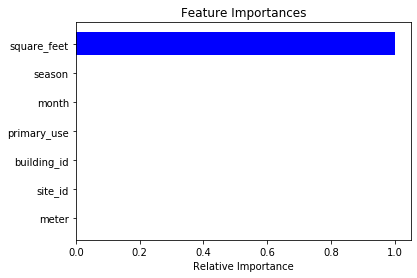

In [58]:

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

# Validation

In [59]:
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
y_pred = model.predict(x_val)
score = np.sqrt(mse(y_val, y_pred))# we use mse not msle since we already make y_val as np.log1p and so the y_pred
print('Val MSE = ', score)

Val MSE =  1.9270517747561233


In [0]:
del train_df
del x_train
del x_val

# Testing

In [0]:
def load_test_data():
  if kaggle:
    test_path = '/kaggle/input/ashrae-energy-prediction/test.csv'
    weather_test_path = '/kaggle/input/ashrae-energy-prediction/weather_test.csv'
    building_train_path = '/kaggle/input/ashrae-energy-prediction/building_metadata.csv'
  else:
    test_path = 'test.csv'
    weather_test_path = 'weather_test.csv'    
    building_train_path = 'building_metadata.csv'
    
  return load_data(test_path, building_train_path, weather_test_path)
  #return pd.merge(pd.merge(pd.read_csv(test_path), pd.read_csv(building_train_path), on='building_id', how='left'), pd.read_csv(weather_test_path), on=['timestamp','site_id'], how='left')

In [0]:

if not kaggle:
  !unzip -n test.csv.zip
  !unzip -n weather_test.csv.zip
  
test_df = load_test_data()
# Test prep and features extraction


test_df = reduce_mem_usage(test_df)

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df["hour"] = test_df["timestamp"].dt.hour
test_df["day"] = test_df["timestamp"].dt.day
test_df["weekday"] = test_df["timestamp"].dt.weekday_name 
test_df["month"] = test_df["timestamp"].dt.month
test_df['year'] = test_df['timestamp'].dt.year

test_df['season'] = test_df.month.apply(month_to_season)
#test_df = reduce_mem_usage(test_df)

x_test = select_features(test_df)
del test_df
x_test, features, categorical_features = prep_features(x_test)

The score predicts to return the abs meter reading, while we predict log(p) + 1. So we must make exp(pred) - 1.

This is all done using np.expm1 (m1 = minus 1)

In [0]:
preds = np.expm1(model.predict(x_test))

# Submission

In [0]:
#!unzip -n sample_submission.csv.zip
if kaggle:
  sample = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
else:
  !unzip -n sample_submission.csv.zip
  sample = pd.read_csv("sample_submission.csv")
sample['meter_reading'] = preds #np.expm1(gbm.predict(x_test))
sample.to_csv('submission.csv', index=False)
sample.head()